# HW2: Variational Autoencoders on Anime Faces

For this exercise, you will train a Variational Autoencoder (VAE) using the [anime faces dataset by MckInsey666](https://github.com/bchao1/Anime-Face-Dataset). 

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

## Parameters

In [2]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=1000
LATENT_DIM=512
IMAGE_SIZE=64

## Download the Dataset

You will download the Anime Faces dataset (https://drive.google.com/file/d/1zfNeltFx2KlGJgpsacGpKmHHPVH4X0ft/view?usp=drive_link) and save it to a local directory.

## Prepare the Dataset

Next is preparing the data for training and validation. We've provided you some utilities below.

In [3]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

You will use the functions above to generate the train and validation sets.

In [4]:
# get the list containing the image paths
paths = get_dataset_slice_paths("./data")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 51
number of batches in the validation set: 13


## Display Utilities

We've also provided some utilities to help in visualizing the data.

In [5]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


Let's see some of the anime faces from the validation dataset.

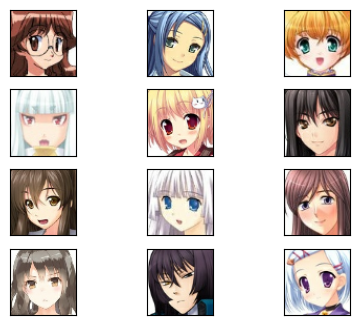

In [6]:
display_faces(validation_dataset, size=12)

## Build the Model

You will be building your VAE in the following sections. Recall that this will follow and encoder-decoder architecture and can be summarized by the figure below.

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

You will start with the custom layer to provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. Recall the equation to combine these:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [7]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    ### START CODE HERE ###
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1] # parameters for building the model and training
    epsilon = tf.random.normal(shape=(batch, dim))
    z = mu + tf.exp(sigma * 0.5) * epsilon
    ### END CODE HERE ###
    return  z

### Encoder Layers

Next, please use the Functional API to stack the encoder layers and output `mu`, `sigma` and the shape of the features before flattening. We expect you to use 3 convolutional layers (instead of 2 in the ungraded lab) but feel free to revise as you see fit. Another hint is to use `1024` units in the Dense layer before you get mu and sigma (we used `20` for it in the ungraded lab).

*Note: If you did Week 4 before Week 3, please do not use LeakyReLU activations yet for this particular assignment. The grader for Week 3 does not support LeakyReLU yet. This will be updated but for now, you can use `relu` and `sigmoid` just like in the ungraded lab.*

In [8]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  x = tf.keras.layers.Conv2D(
    filters=16, kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer='he_uniform'
    )(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(
    filters=16, kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer='he_uniform'
    )(x)
  x = tf.keras.layers.BatchNormalization()(x)
  batch_3 = tf.keras.layers.Conv2D(
    filters=8 , kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer='he_uniform'
  )(x)
  x = tf.keras.layers.BatchNormalization()(batch_3)
  x = tf.keras.layers.Flatten()(x)
  mu      = tf.keras.layers.Dense(units=latent_dim, activation=None)(x)
  sigma   = tf.keras.layers.Dense(units=latent_dim, activation=None)(x)

  mu = tf.keras.layers.Dropout(rate=0.1)(mu)
  sigma = tf.keras.layers.Dropout(rate=0.1)(sigma)
  ### END CODE HERE ###

  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

### Encoder Model

You will feed the output from the above function to the `Sampling layer` you defined earlier. That will have the latent representations that can be fed to the decoder network later. Please complete the function below to build the encoder network with the `Sampling` layer.

In [9]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs = [mu, sigma, z])
  ### END CODE HERE ###
  model.summary()
  return model, conv_shape

### Decoder Layers

Next, you will define the decoder layers. This will expand the latent representations back to the original image dimensions. After training your VAE model, you can use this decoder model to generate new data by feeding random inputs.

In [10]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  ### START CODE HERE ###
  # reshape the output from flat to conv shape
  reshape = tf.keras.layers.Reshape(target_shape=(conv_shape[1], conv_shape[2], conv_shape[3]))(inputs)
  batch_1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(reshape)
  batch_2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(batch_1)
  batch_3 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(batch_2)
  output  = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(batch_3) # output layer with 3 channels

  x = output
  ### END CODE HERE ###
  return x

### Decoder Model

Please complete the function below to output the decoder model.

In [11]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  ### END CODE HERE ###
  model.summary()
  return model

### Kullback–Leibler Divergence

Next, you will define the function to compute the [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) loss. This will be used to improve the generative capability of the model. This code is already given.


In [12]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.math.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together

Please define the whole VAE model. Remember to use `model.add_loss()` to add the KL reconstruction loss. This will be accessed and added to the loss later in the training loop.

In [13]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed = decoder(z)

  model = tf.keras.Model(inputs, reconstructed)

  recon_loss = kl_reconstruction_loss(inputs, z, mu, sigma)

  model.add_loss(recon_loss)
  ### END CODE HERE ###
  return model

Next, please define a helper function to return the encoder, decoder, and vae models you just defined.


In [14]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  ### START CODE HERE ###
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)


  ### END CODE HERE ###
  return encoder, decoder, vae

Let's use the function above to get the models we need in the training loop.


In [15]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 16)           2320      ['batch_normalization[0]

## Train the Model

You will now configure the model for training. We defined some losses, the optimizer, and the loss metric below but you can experiment with others if you like.


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

You will generate 16 images in a 4x4 grid to show
progress of image generation. We've defined a utility function for that below.

In [17]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

You can now start the training loop. You are asked to select the number of epochs and to complete the subection on updating the weights. The general steps are:

* feed a training batch to the VAE model
* compute the reconstruction loss (hint: use the **mse_loss** defined above instead of `bce_loss` in the ungraded lab, then multiply by the flattened dimensions of the image (i.e. 64 x 64 x 3)
* add the KLD regularization loss to the total loss (you can access the `losses` property of the `vae` model)
* get the gradients
* use the optimizer to update the weights


When training your VAE, you might notice that there’s not a lot of variation in the faces. But don’t let that deter you! We’ll test based on how well it does in reconstructing the original faces, and not how well it does in creating new faces.

The training will also take a long time (more than 30 minutes) and that is to be expected. If you used the mean loss metric suggested above, train the model until that is down to around 320 before submitting.


1/1 [==============================] - 0s 21ms/step


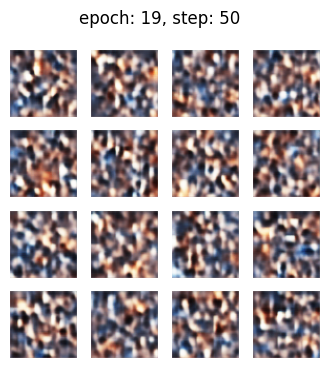

Epoch: 19 step: 50 mean loss = 246.8823


In [18]:
# Training loop. Display generated images each epoch

### START CODE HERE ###
epochs = 20
### END CODE HERE ###

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      ### START CODE HERE ### 
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape = [-1])
      flattened_outputs = tf.reshape(reconstructed, shape = [-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 64 * 64 * 3
      loss += sum(vae.losses)
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    ### END CODE HERE
    
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

# Plot Reconstructed Images


As mentioned, your model will be graded on how well it is able to reconstruct images (not generate new ones). You can get a glimpse of how it is doing with the code block below. It feeds in a batch from the test set and plots a row of input (top) and output (bottom) images. Don't worry if the outputs are a blurry. It will look something like below:

<img src="https://drive.google.com/uc?export=view&id=1OPMbZOxX9fx8tK6CGVbrMaQdgyOiQJIC" width="75%" height="60%"/>

1/1 [==============================] - 1s 622ms/step


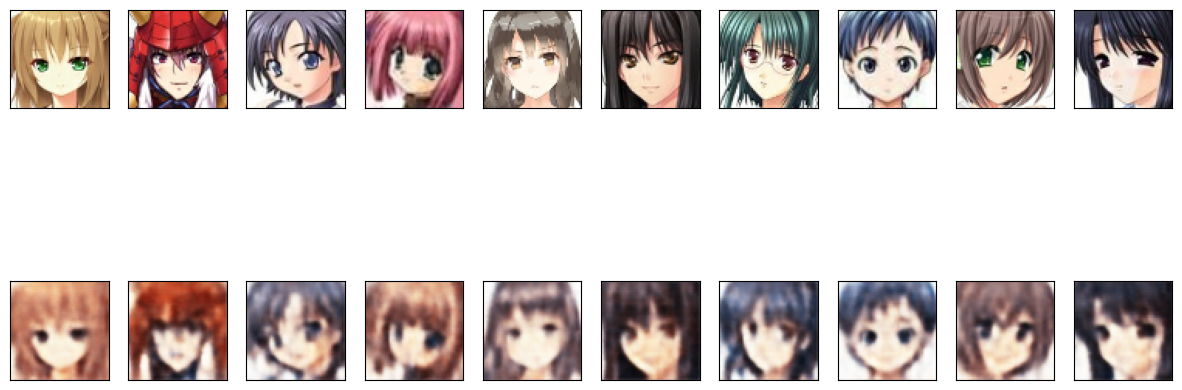

In [19]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

# Plot Generated Images


Using the default parameters, it can take a long time to train your model well enough to generate good fake anime faces. In case you decide to experiment, we provided the code block below to display an 8x8 gallery of fake data generated from your model. Here is a sample gallery generated after 50 epochs.

<img src="https://drive.google.com/uc?export=view&id=1QwElgfg5TY6vCgI1FK6vdI8Bo6UZKfuX" width="75%" height="60%"/>

2/2 [==============================] - 0s 8ms/step


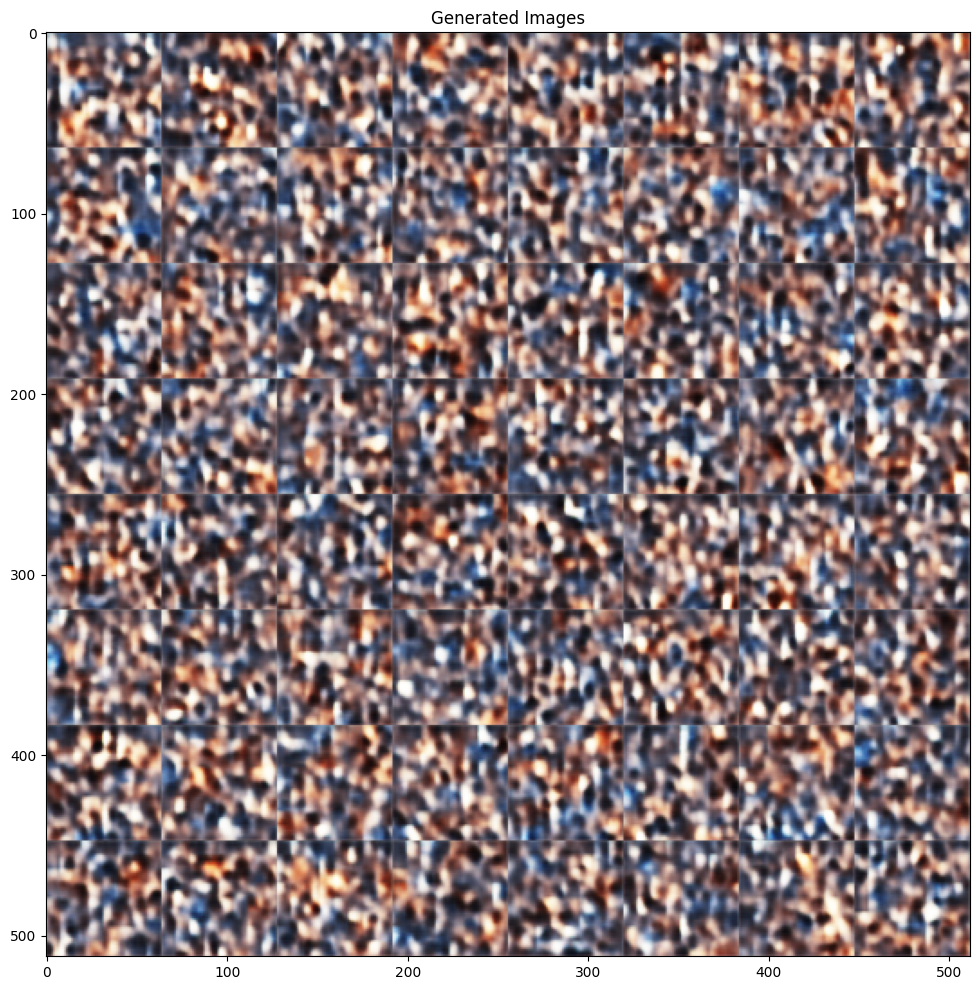

In [20]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')